#### Summarization with LLMs

In [1]:
import numpy as np
import pandas as pd
##Import necessary libraries
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import GenerationConfig # To control the parameters of text generation

In [2]:
##Select and use a summarization dataset
data_0 = load_dataset("xsum")
data_1 = load_dataset("samsum")
data_2 = load_dataset("knkarthick/dialogsum")

Found cached dataset xsum (/home/daniel/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset samsum (/home/daniel/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset csv (/home/daniel/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-c07c4cf4362c223c/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/3 [00:00<?, ?it/s]

#### Explore, preprocess and clean the data

In [3]:
def calculate_len(from_column, to_column):
    def cal_len(x):
        x["origin_len"] = len(x[from_column])
        x["summary_len"] = len(x[to_column])
        x["text"] = x[from_column]
        if x["origin_len"] > 0:
            x["summary_percentage"] = x["summary_len"] / x["origin_len"]
        else:
            x["summary_percentage"] = 2
        return x
    return cal_len


In [4]:
ds_0 = data_0.map(calculate_len("document", "summary"), num_proc=4, remove_columns=["document", "id"])
ds_1 = data_1.map(calculate_len("dialogue", "summary"), num_proc=4, remove_columns=["dialogue", "id"])
ds_2 = data_2.map(calculate_len("dialogue", "summary"), num_proc=4, remove_columns=["dialogue", "id", "topic"])

ds_0 = ds_0.filter(lambda x: (x["summary_percentage"] < 0.85 and x["summary_len"] > 15))
ds_1 = ds_1.filter(lambda x: (x["summary_percentage"] < 0.85 and x["summary_len"] > 15))
ds_2 = ds_2.filter(lambda x: (x["summary_percentage"] < 0.85 and x["summary_len"] > 15))

Loading cached processed dataset at /home/daniel/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71/cache-d6fa550143def4d2_*_of_00004.arrow
Loading cached processed dataset at /home/daniel/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71/cache-a1555ee2dc62210c_*_of_00004.arrow
Loading cached processed dataset at /home/daniel/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71/cache-d39eed4b90ad9bd1_*_of_00004.arrow
Loading cached processed dataset at /home/daniel/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e/cache-98bb748469ac11d5_*_of_00004.arrow
Loading cached processed dataset at /home/daniel/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e/cache-6213d5f23506be4e_*_of_00004

In [5]:
pd_0 = ds_0["train"].to_pandas()
pd_0["dataset"] = "xsum"
pd_1 = ds_1["train"].to_pandas()
pd_1["dataset"] = "samsum"
pd_2 = ds_2["train"].to_pandas()
pd_2["dataset"] = "knkarthick/dialogsum"

In [6]:
pd_all = pd.concat([pd_0, pd_1, pd_2])

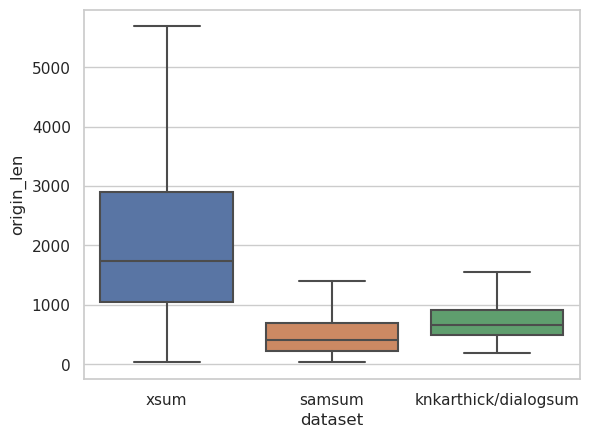

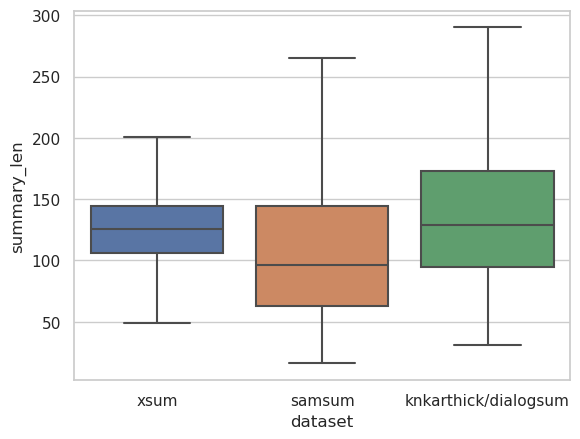

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

sns.boxplot(x="dataset", y="origin_len", data=pd_all, showfliers=False)
plt.show()
sns.boxplot(x="dataset", y="summary_len", data=pd_all, showfliers=False)
plt.show()

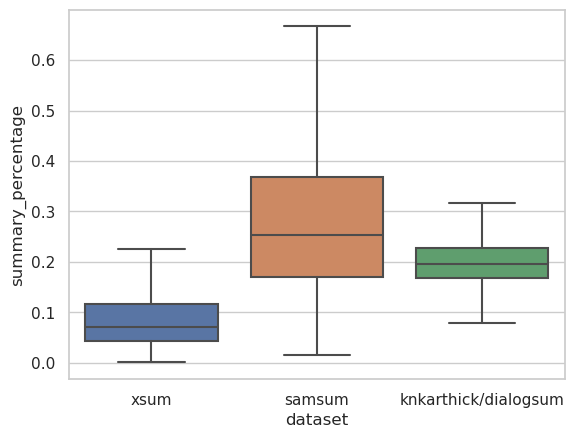

In [8]:
sns.boxplot(x="dataset", y="summary_percentage", data=pd_all, showfliers=False);

In [9]:
model_checkpoint = "google/flan-t5-large"
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [11]:
for i in [0,1,2,45,50,60]:
    print("Text:")
    text = "summarize: \n" + ds_2["train"][i]["text"]
    inputs = tokenizer(text, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    generation = model.generate(**inputs, max_new_tokens=50)
    gen_text = tokenizer.batch_decode(generation, skip_special_tokens=True)
    print(text)
    print("Generation:")
    print(gen_text[0])
    print("\n")


Text:
summarize: 
#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?
#Person2#: I found it would be a good idea to get a check-up.
#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.
#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?
#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.
#Person2#: Ok.
#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?
#Person2#: Yes.
#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.
#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.
#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.
#Person2#: Ok, thanks doctor.
Generation:
Person2 is here for a check-up. He has

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in [0,1,2,45,50,60]:
    print("Text:")
    text = "summarize: \n" + ds_2["train"][i]["text"]
    inputs = tokenizer(text, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    generation = model.generate(**inputs, max_new_tokens=50, num_beams=5, do_sample=True)
    gen_text = tokenizer.batch_decode(generation, skip_special_tokens=True)
    print(text)
    print("Generation:")
    print(gen_text[0])
    print()

Text:
summarize: 
#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?
#Person2#: I found it would be a good idea to get a check-up.
#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.
#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?
#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.
#Person2#: Ok.
#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?
#Person2#: Yes.
#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.
#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.
#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.
#Person2#: Ok, thanks doctor.
Generation:
Mr. Smith hasn't had a check-up in 5 y

In [31]:
text = "write the shell command to change conda enviroment"
inputs = tokenizer(text, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
generation = model.generate(**inputs, max_new_tokens=50)
tokenizer.batch_decode(generation, skip_special_tokens=True)

['sys -l "conda enviroment"']